 ##### Ejemplos prácticos Data Science - Agustina Torres Moray.

## PIPELINE

### GRID SEARCH / CUSTOM DATA TRANSFORMERS / FEATURE UNION

#### Dataset

Trabajaremos con el siguiente dataset  https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

#### Objetivo:

Construir un modelo para la clasificación de vinos a traves de un pipeline con Grid Search, de manera de optimitar los pasos del preprocesamiento y entrenamiento, así como identificar cuales de estos son los que mejor performan de las diferentes alternativas.

### DESARROLLO

#### 1 - Importar librerías necesarias.

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

#### 2 - EDA y Preprocesamiento

In [6]:
df = pd.read_csv('winequality-red.csv',sep=';')

In [7]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
df.shape

(1599, 12)

In [9]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [15]:
df.value_counts('quality')

quality
5    681
6    638
7    199
4     53
8     18
3     10
dtype: int64

In [20]:
df['quality_bin']=df['quality'].apply(lambda x: 1 if x>=6 else 0)

In [22]:
df['quality_bin'].value_counts(normalize=True)

1    0.534709
0    0.465291
Name: quality_bin, dtype: float64

In [24]:
X=df.drop(columns=['quality','quality_bin'])
y=df['quality_bin']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=30, test_size=0.30,stratify=y)

In [29]:
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1119, 11)

(480, 11)

(1119,)

(480,)

Graficamos un heatmap que contemple las correlaciones entre las features así como el impacto de estas últimas sobre la varibale target.

<AxesSubplot:>

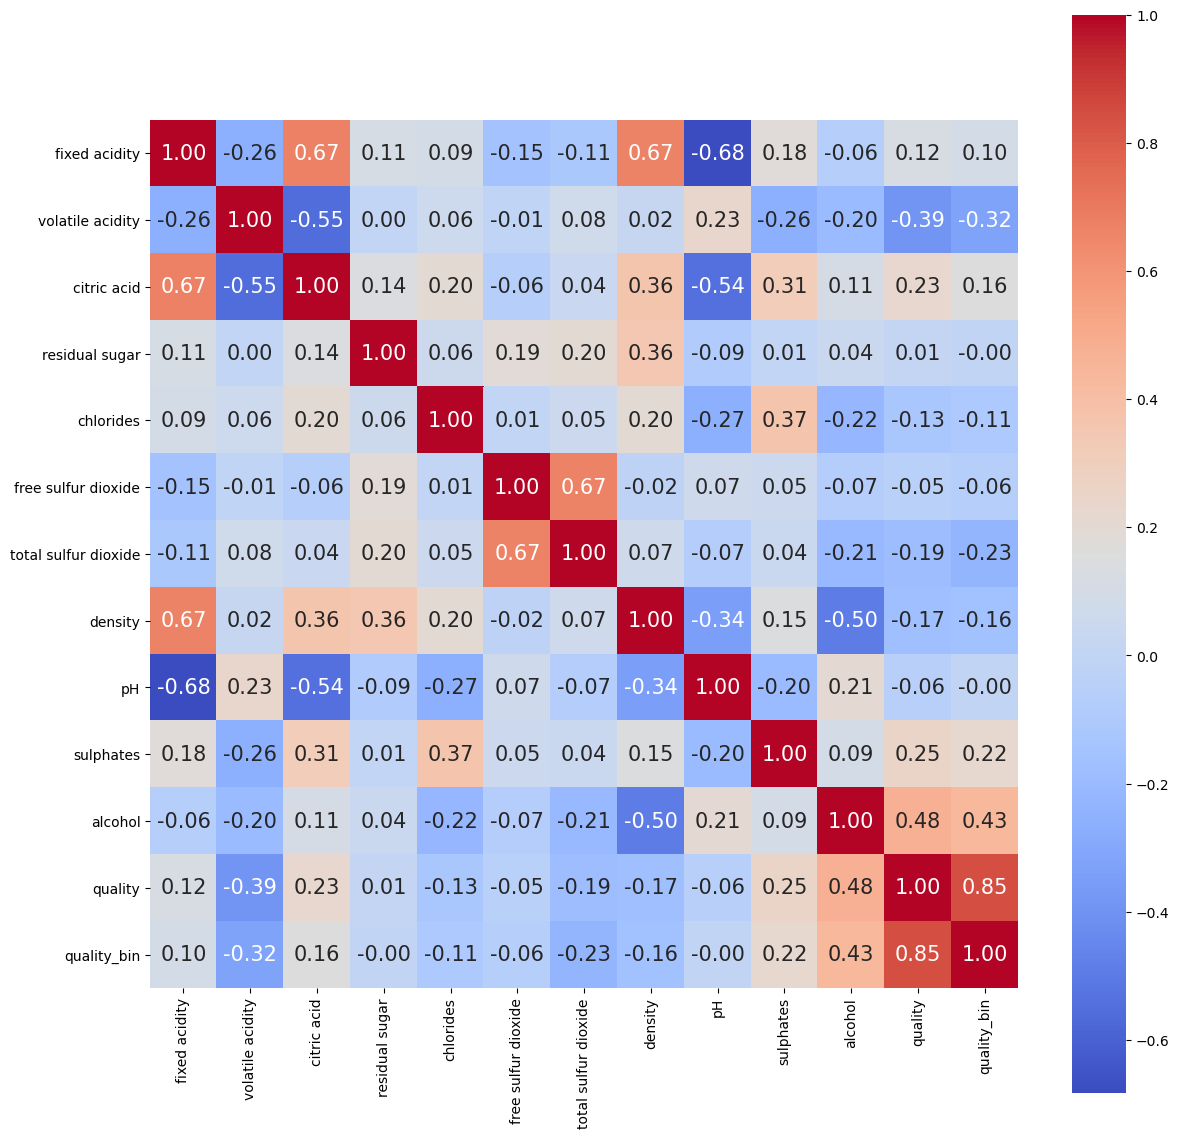

In [32]:
corr = df.corr(method="pearson")

plt.figure(figsize=(14,14))
sns.heatmap(corr,cbar=True,square=True,annot=True,fmt='.2f',annot_kws={'size': 15},
           xticklabels= df.columns,
           yticklabels= df.columns,
           cmap= 'coolwarm')

#### 3 - PIPELINE + GRID-SEARCH

Al aplicar un pipeline con Grid Search, lo que buscamos es:
    1 - Crear un custom data transformation para feature selection de manera de poder identificar si es mejor contemplar o no el azucar residual para el modelado ( el heatmap muestra una correlación no significativa).
    2 - Identificar la mejor herramienta de normalización de datos numéricos para nuestro caso bajo estudio.
    3 - Identificar el valor óptimo del hiperparámetro C dentro de nuestro estimador de Regresión Logística.

Primer paso: creamos la clase para la selección de features.

In [33]:
class FeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self,selected_features):
        self.selected_features = selected_features
        
    def fit(self,X,y=None):
        return self
    
    def transform (self,X,y=None):
        return X[self.selected_features]
    

Segundo paso: definimos los pasos para el Pipeline y lo instanciamos

In [34]:
selector = FeatureSelection(selected_features = X.drop(columns = 'residual sugar').columns.values)

In [36]:
pasos = [('feature_engineering', selector),('preprocesamiento',MinMaxScaler()),('clasificador', LogisticRegression(solver='lbfgs'))]

In [37]:
pipe = Pipeline(pasos)

Tercer Paso: generamos la grilla y aplicamos GridSearch

In [39]:
folds = StratifiedKFold(n_splits=5, shuffle= True,random_state=42 )

In [40]:
param_grid= [{'feature_engineering':[selector, None],
               'preprocesamiento':[StandardScaler(), MinMaxScaler()],
               'clasificador__C':np.linspace(0.1,1000,100)}]

In [41]:
grid = GridSearchCV(pipe,param_grid,cv=folds)

In [42]:
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('feature_engineering',
                                        FeatureSelection(selected_features=array(['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH',
       'sulphates', 'alcohol'], dtype=object))),
                                       ('preprocesamiento', MinMaxScaler(...
       9.091e+02, 9.192e+02, 9.293e+02, 9.394e+02, 9.495e+02, 9.596e+02,
       9.697e+02, 9.798e+02, 9.899e+02, 1.000e+03]),
                          'feature_engineering': [FeatureSelection(selected_features=array(['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH',
       'sulphates', 'alcohol'], dtype=object)),
                                                  None],
                          'preprocesamiento': [StandardSca

Cuarto paso: evaluamos el mejor modelo y su score asociado.

In [44]:
grid.best_estimator_

Pipeline(steps=[('feature_engineering', None),
                ('preprocesamiento', MinMaxScaler()),
                ('clasificador', LogisticRegression(C=70.8))])

In [45]:
grid.best_params_

{'clasificador__C': 70.8,
 'feature_engineering': None,
 'preprocesamiento': MinMaxScaler()}

In [46]:
grid.best_score_

0.7354620435618193

Quinto y último paso: predecimos y calculamos la performance con los datos de test.

In [47]:
grid.best_estimator_.score(X_test,y_test)

0.75625